# Estimación de ruido mediante análisis de segmentos

In [1]:
import os
import numpy as np
import json
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.stats import norm

%load_ext autoreload
%autoreload 2
%matplotlib inline

Leemos la data extraida del slice

In [9]:
data_path = 'infosaves'
data_dict = {}
hist_dict = {}
for image in os.listdir(data_path):
    for file in os.listdir(os.path.join(data_path, image)):
        if file.endswith('.json'):
            data_dict[image] = json.load(open(os.path.join(data_path, image, file), 'r'))
        elif file.endswith('.csv'):
            hist_dict[image] = pd.read_csv(os.path.join(data_path, image, file))
            

### Reconstruimos el ruido con media y varianza

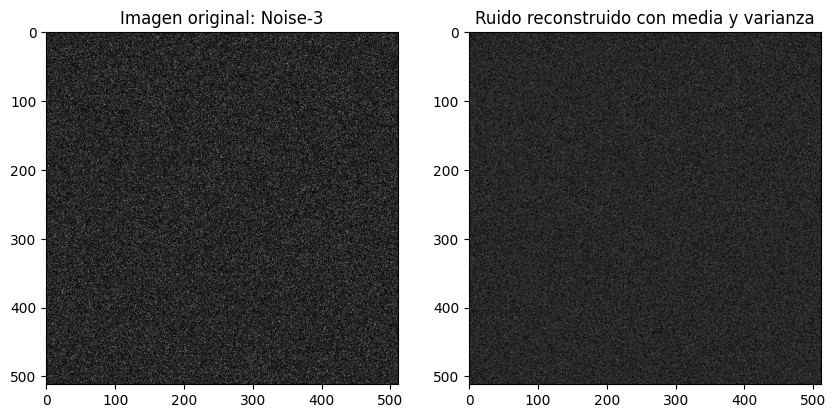

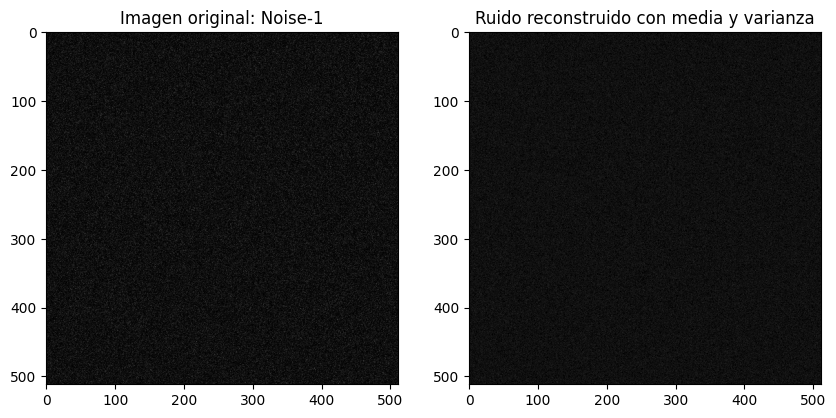

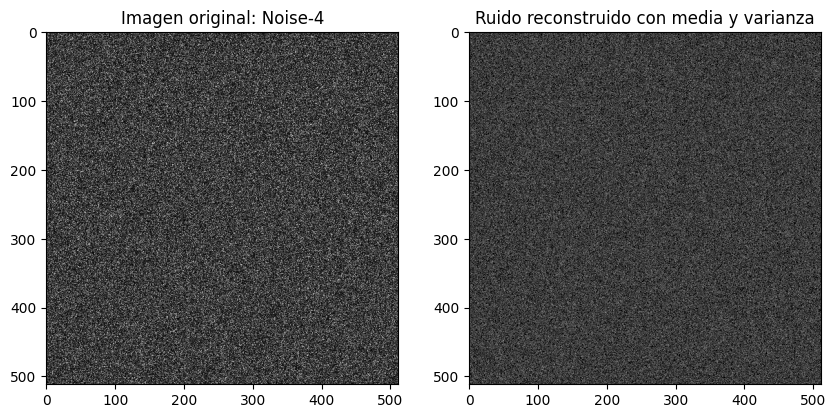

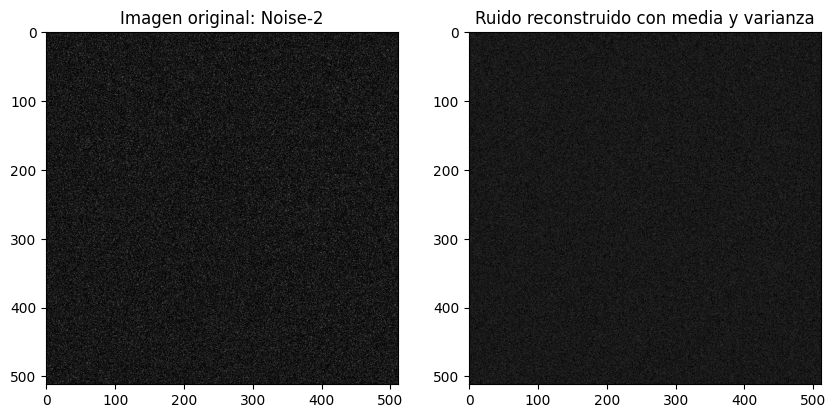

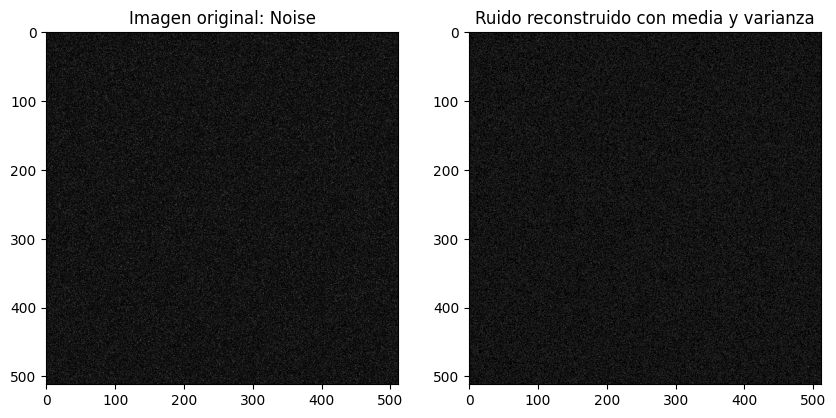

In [11]:
noise_dir = 'PAIByB-1'
output_dir = 'noise_estimation/stat_estimation'

for fname in os.listdir(noise_dir):
    noise = fname.split('.')[0]
    ruido_real = cv2.imread(os.path.join(noise_dir, fname), cv2.IMREAD_GRAYSCALE)
    stats = data_dict[noise]
    ruido_reconstruido = np.random.normal(loc=stats['mean'], 
                                          scale=stats['desv_est'],
                                          size=ruido_real.shape)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(ruido_real, vmin=0, vmax=255, cmap='gray')
    axs[0].set_title(f'Imagen original: {noise}')
    axs[1].imshow(ruido_reconstruido, vmin=0, vmax=255, cmap='gray')
    axs[1].set_title('Ruido reconstruido con media y varianza')
    plt.show()
    
    cv2.imwrite(os.path.join(output_dir, f"{noise}_stat.png"), ruido_reconstruido)

### Ajuste de distribuciones normales al histograma analizando media y varianza del segmento

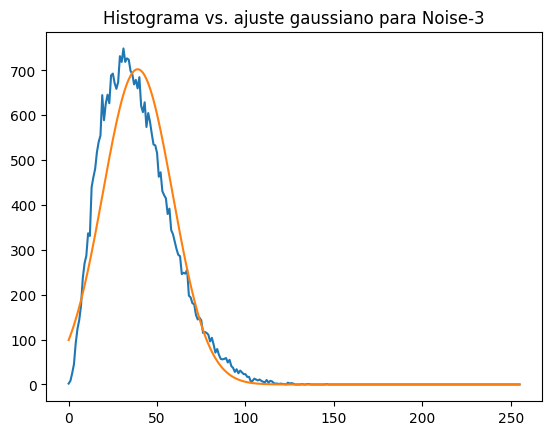

DMA=15.758


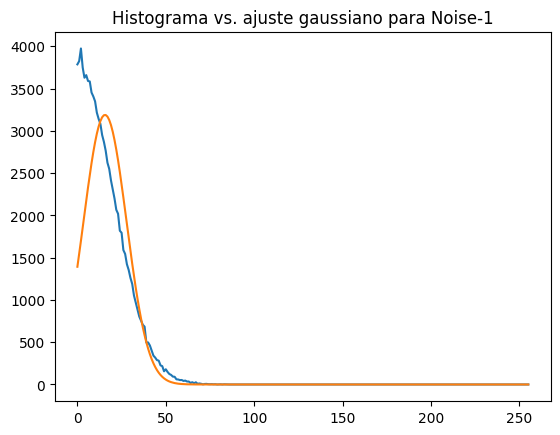

DMA=9.724


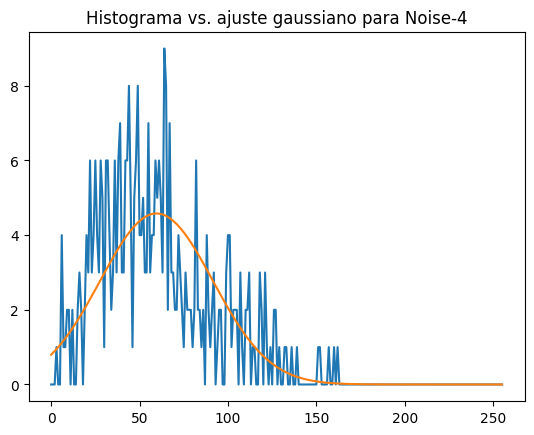

DMA=25.294


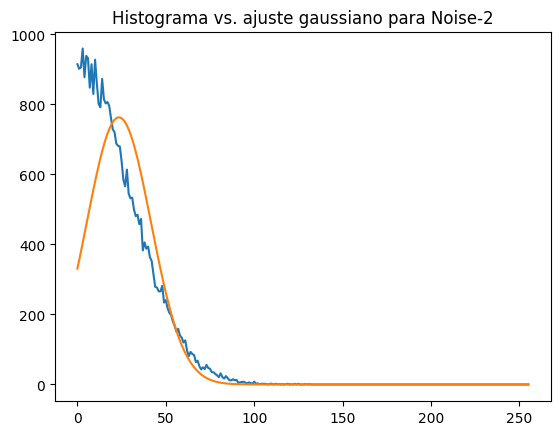

DMA=14.517


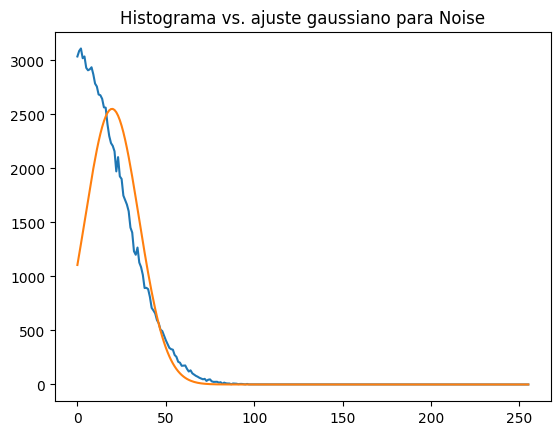

DMA=12.140


In [12]:
hist_stats_dict = {}

for fname in os.listdir(noise_dir):
    noise = fname.split('.')[0]
    hist_df = hist_dict[noise]
    I, h = hist_df['gray_lvl'], hist_df['hist_value']
    mu = np.dot(I, h) / h.sum()
    sigma = np.sqrt(np.dot((I - mu)**2, h) / h.sum())
    bell_curve = norm.pdf(x=I, loc=mu, scale=sigma) * h.sum()
    
    fig, ax = plt.subplots()
    ax.plot(hist_df['gray_lvl'], hist_df['hist_value'])
    ax.plot(hist_df['gray_lvl'], bell_curve)
    ax.set_title(f'Histograma vs. ajuste gaussiano para {noise}')
    plt.show()
    
    # Calculo DMA
    DMA = np.abs(I - mu).dot(h) / h.sum()
    print(f"{DMA=:.3f}")
    
    # Guardado de parametros
    hist_stats_dict[noise] = (mu, sigma)

## Reconstrucción de ruido por análisis del histograma

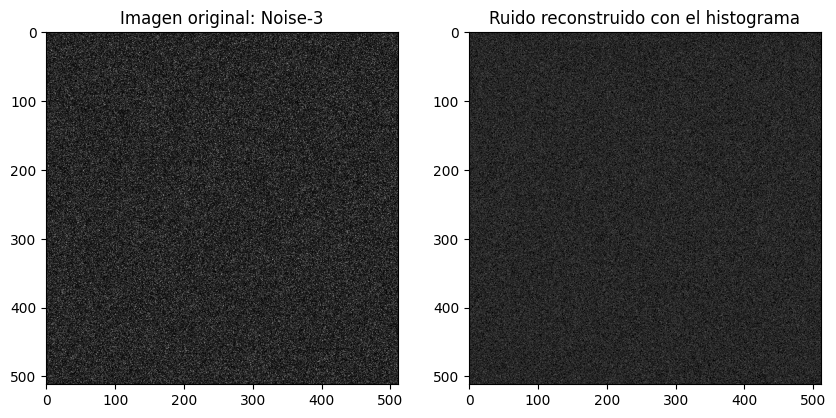

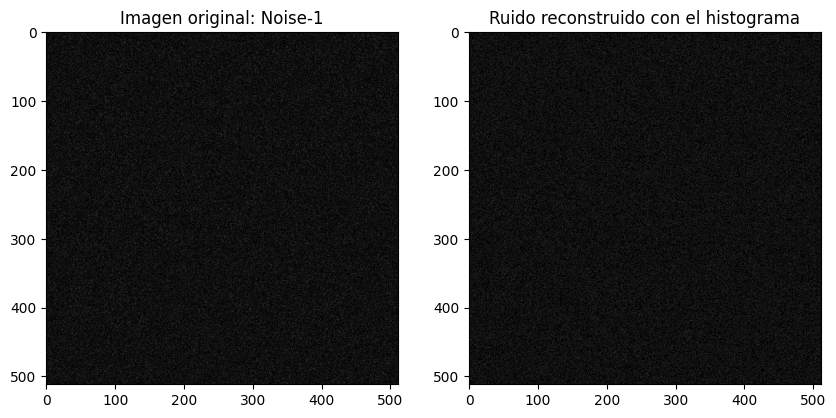

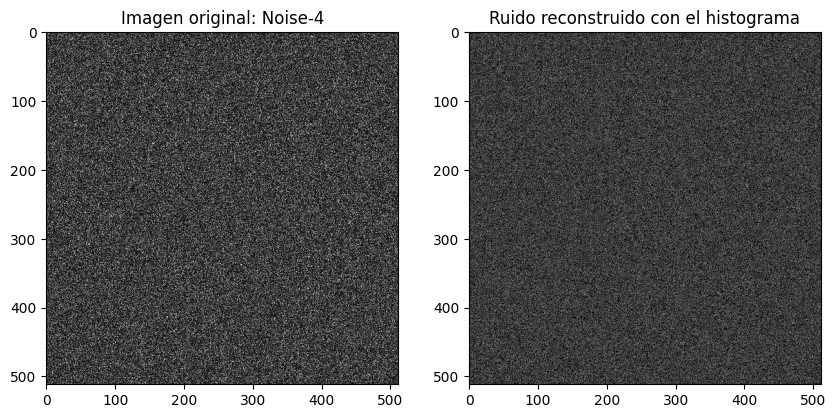

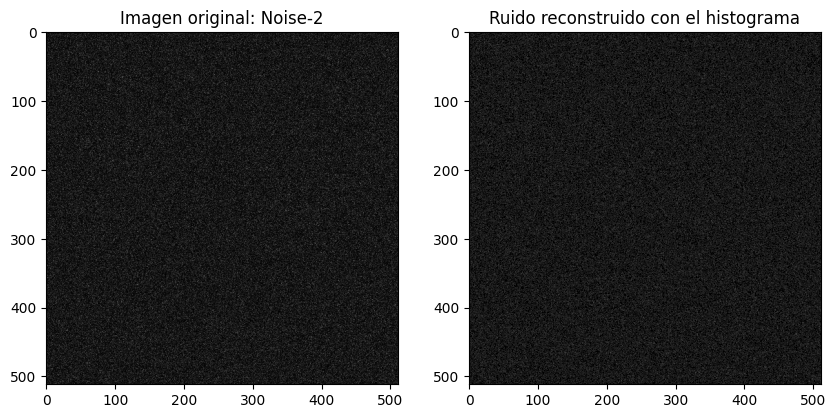

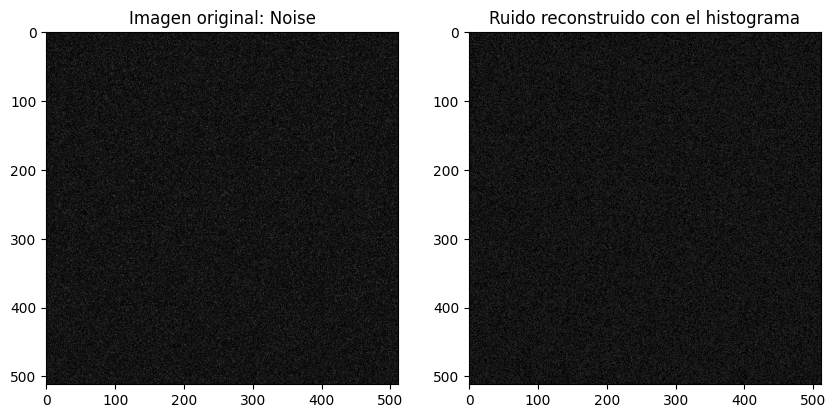

In [14]:
for noise, (mu, sigma) in hist_stats_dict.items():
    fname = f"{noise}.tif"
    ruido_real = cv2.imread(os.path.join(noise_dir, fname), cv2.IMREAD_GRAYSCALE)
    ruido_reconstruido = np.random.normal(loc=mu, 
                                          scale=sigma,
                                          size=ruido_real.shape)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(ruido_real, vmin=0, vmax=255, cmap='gray')
    axs[0].set_title(f'Imagen original: {noise}')
    axs[1].imshow(ruido_reconstruido, vmin=0, vmax=255, cmap='gray')
    axs[1].set_title('Ruido reconstruido con el histograma')
    plt.show()
    
    cv2.imwrite(os.path.join(output_dir, f"{noise}_hist.png"), ruido_reconstruido)